# 21. 多智能体强化学习进阶

## 21.1 简介
- 第 20 章中已经初步介绍了多智能体强化学习研究的问题和最基本的求解范式。本章来介绍一种比较经典且效果不错的进阶范式：**中心化训练去中心化执行**（centralized training with decentralized execution，CTDE）。所谓中心化训练去中心化执行是指在训练的时候使用一些单个智能体看不到的全局信息而以达到更好的训练效果，而在执行时不使用这些信息，每个智能体完全根据自己的策略直接动作以达到去中心化执行的效果。中心化训练去中心化执行的算法能够在训练时有效地利用全局信息以达到更好且更稳定的训练效果，同时在进行策略模型推断时可以仅利用局部信息，使得算法具有一定的扩展性。CTDE 可以类比成一个足球队的训练和比赛过程：在训练时，11 个球员可以直接获得教练的指导从而完成球队的整体配合，而教练本身掌握着比赛全局信息，教练的指导也是从整支队、整场比赛的角度进行的；而训练好的 11 个球员在上场比赛时，则根据场上的实时情况直接做出决策，不再有教练的指导。

- CTDE 算法主要分为两种：一种是基于值函数的方法，例如 VDN，QMIX 算法等；另一种是基于 Actor-Critic 的方法，例如 MADDPG 和 COMA 等。本章将重点介绍 MADDPG 算法。

## 21.2 MADDPG 算法
- 多智能体 DDPG（muli-agent DDPG，MADDPG）算法从字面意思上来看就是对于每个智能体实现一个 DDPG 的算法。所有智能体共享一个中心化的 Critic 网络，该 Critic 网络在训练的过程中同时对每个智能体的 Actor 网络给出指导，而执行时每个智能体的 Actor 网络则是完全独立做出行动，即去中心化地执行。

- CTDE 算法的应用场景通常可以被建模为一个**部分可观测马尔可夫博弈**（partially observable Markov games）：用 $\mathcal{S}$ 代表 $N$ 个智能体所有可能的状态空间，这是全局的信息。对于每个智能体 $i$，其动作空间为 $\mathcal{A}_i$，观测空间 $\mathcal{O}_i$，每个智能体的策略 $\pi_{\theta_{i}}:\mathcal{O}_{i}\times\mathcal{A}_{i}\to[0,1]$ 是一个概率分布，用来表示智能体在每个观测下采取各个动作的概率。环境的状态转移函数为：$\mathcal{T}:\mathcal{S}\times\mathcal{A}_{1}\times\cdots\times\mathcal{A}_{N}\to\Omega(\mathcal{S})$。每个智能体的奖励函数为 $r_{i}:\mathcal{S}\times\mathcal{A}\to\mathbb{R}$，每个智能体从全局状态得到的部分观测信息为 $\mathbf{o}_{i}:\mathcal{S}\to\mathcal{O}_{i}$，初始状态分布为 $\rho:\mathcal{S} \to [0,1]$。每个智能体的目标是最大化其期望累计奖励 $\mathbb{E}[\sum_{t = 0}^T \gamma^tr_i^t]$。

- 接下来我们看一下 MADDPG 算法的主要细节吧！如图 21-1 所示，每个智能体用 Actor-Critic 的方法训练，但不同于传统单智能体的情况，在 MADDPG 中每个智能体的 Critic 部分都能够获得其他智能体的策略信息。具体来说，考虑一个有 $N$ 个智能体的博弈，每个智能体的策略参数为 $\theta = \{ \theta_1, \dots, \theta_N\}$，记 $\pi = \{\pi_1, \dots, \pi_N\}$ 为所有智能体的策略集合，那么我们可以写出在随机性策略情况下每个智能体的期望收益的策略梯度：

$$
\nabla_{\theta,}J(\theta_i)=\mathbb{E}_{s\sim p^\mu,a\sim\pi_i}[\nabla_{\theta_i}\log\pi_i(a_i|o_i)Q_i^\pi(\mathbf{x},a_1,\ldots,a_N)]
$$

- 其中，$Q_i^{\pi}(\mathbf{x}, a_1, \dots, a_N)$ 就是一个中心化的动作价值函数。为什么说 $Q_i$ 是一个中心化的动作价值函数呢？一般来说 $\mathbf{x} = (o_1,\dots, o_N)$ 包含了所有智能体的观测，另外 $Q_i$ 也需要输入所有智能体在此刻的动作，因此 $Q_i$ 工作的前提就是所有智能体要同时给出自己的观测和相应的动作。 

<div align="center" style="text-align: center;">
    <img src="./image/21-1.png" style="width: 40%;">
    <center>图 21-1 MADDPG 算法总览图</center>
</div> 

- 对于确定性策略来说，考虑现在有 $N$ 个连续的策略 $\mu_{\theta_i}$，可以得到 DDPG 的梯度公式：

$$
\nabla_{\theta_i}J(\mu_i)=\mathbb{E}_{\mathbf{x}\sim\mathcal{D}}[\nabla_{\theta_i}\mu_i(o_i)\nabla_{a_i}Q_i^\mu(\mathbf{x},a_1,\ldots,a_N)|_{a_i=\mu_i(o_i)}]
$$

- 其中，$\mathcal{D}$ 是我们用来存储数据的经验放回池，它存储的每一个数据为 $(\mathbf{x},\mathbf{x}',a_1, \dots, a_N, r_1, \dots, r_N)$。而在 MADDPG 中，中心化动作价值函数可以按照下面的损失函数来更新：

$$
\mathcal{L}(\omega_i)=\mathbb{E}_{\mathbf{x},a,r,\mathbf{x}^{\prime}}[(Q_i^\mu(\mathbf{x},a_1,\ldots,a_N)-y)^2],y=r_i+\gamma Q_i^{\mu^{\prime}}(\mathbf{x}^{\prime},a_1^{\prime},\ldots,a_N^{\prime})|_{a_j^{\prime}=\mu_j^{\prime}(o_j)}
$$

- 其中，$\mu' = (\mu_{\theta}', ..., \mu_{\theta_N}')$ 是更新价值函数中使用的目标策略的集合，他们有着延迟更新的参数。

- MADDPG 的具体算法流程如下：
    - 随机初始化每个智能体的 Actor 网络和 Critic 网络
    - for 序列 $e = 1 \to E$ do:
        - 初始化一个随机过程 $\,athcal{N}$，用于动作探索；
        - 获取所有智能体的初始观测 $\mathbf{x}$；
        - for $t = 1 \to T$ do:
            - 对于每个智能体 $i$，用当前的策略选择一个动作 $a_i = \mu_{\theta_i}(o_i) + \mathcal{N}_t$；
            - 执行动作 $a = (a_1, \dots, a_N)$ 并且获得奖励 $r$ 和新的观测 $\mathbf{x}'$；
            - 把 $(\mathbf{x},a,r,\mathbf{x}')$ 存储到经验回放池 $\mathcal{D}$ 中；
            - 从 $\mathcal{D}$ 中随机采样一些数据；
            - 对于每个智能体 $i$，中心化训练 Critic 网络
            - 对于每个智能体 $i$，训练自身的 Actor 网络
            - 对每个智能体 $i$，更新目标 Actor 网络和目标 Critic 网络
        - end for
    - end for
    
## 21.3 MADDPG 代码实践
- 下面我们来看看如何实现 MADDPG 算法，首先是导入一些需要用到的包。

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils

/home/wxl/anaconda3/envs/rl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 我们要使用的环境为多智能体粒子环境（multiagent particles environment，MPE），它是一些面向多智能体交互的环境的集合，在这个环境中，粒子智能体可以移动、通信、“看”到其他智能体，也可以和固定位置的地标交互。

- 接下来安装环境，由于 MPE 的官方仓库的代码已经不再维护了，而其依赖于 gym 的旧版本，因此我们需要重新安装 gym 库。

In [2]:
!git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
!pip install -e multiagent-particle-envs
import sys
sys.path.append("multiagent-particle-envs")
# 由于multiagent-pariticle-env底层的实现有一些版本问题,因此gym需要改为可用的版本
!pip install --upgrade gym==0.10.5 -q
import gym
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios


def make_env(scenario_name):
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

fatal: destination path 'multiagent-particle-envs' already exists and is not an empty directory.
Obtaining file:///home/wxl/xyb/RL-Study/multiagent-particle-envs
  Preparing metadata (setup.py) ... done
  Attempting uninstall: multiagent
    Found existing installation: multiagent 0.0.1
    Uninstalling multiagent-0.0.1:
      Successfully uninstalled multiagent-0.0.1
  Running setup.py develop for multiagent


- 本章选择 MPE 中的 `simple_adversary` 环境作为代码实践的示例，如图 21-2 所示。该环境中有 1 个红色的对抗智能体（adversary）、$N$ 个蓝色的正常智能体，以及 $N$ 个地点（一般 $N = 2$），这 $N$ 个地点中有一个是目标地点（绿色）。这 $N$ 个正常智能体知道哪一个是目标地点，但对抗智能体不知道。正常智能体是合作关系：它们其中任意一个距离目标地点足够近，则每个正常智能体都能获得相同的奖励。对抗智能体如果距离目标地点足够近，也能获得奖励，但它需要猜哪一个才是目标地点。因此，正常智能体需要进行合作，分散到不同的坐标点，以此欺骗对抗智能体。

<div align="center" style="text-align: center;">
    <img src="./image/21-2.gif" style="width: 40%;">
    <center>图 21-2 MPE 中的 simple_adversary 环境</center>
</div> 

- 需要说明的是，MPE 环境中的每个智能体的动作空间是离散的。第 13 章介绍过 DDPG 算法本身需要使智能体的动作对于其策略参数可导，这对连续的动作空间来说是成立的，但是对于离散的动作空间并不成立。但这并不意味着当前的任务不能使用 MADDPG 算法求解，因为我们可以使用一个叫作 Gumbel-Softmax 的方法来得到离散分布的近似采样。下面我们对其原理进行简要的介绍并给出实现代码。

- 假设有一个随机变量 $Z$ 服从某个离散分布 $\mathcal{K}=(a_1, \dots, a_k)$。其中，$a_i \in [0,1]$ 表示 $P(Z = i)$ 并且满足 $\sum_{i = 1}^ka_i = 1$。当我们希望按照这个分布即 $z \sim \mathcal{K}$ 进行采样时，可以发现这种离散分布的采样是不可导的。

- 那有没有什么办法可以让离散分布的采样可导呢？答案是肯定的！那就是重参数化方法，这一方法在第 14 章的 SAC 算法中已经介绍过，而这里要用的是 Gumbel-Softmax 技巧。具体来说，我们引入一个重参数因子 $g_i$，它是一个采样自 $\mathrm{Gumbel}(0,1)$ 的噪声：

$$
g_i=-\log(-\log u),u\sim\mathrm{Uniform}(0,1)
$$

- Gumbel-Softmax 采样可以写成

$$
y_i=\frac{\exp((\log a_i+g_i)/\tau)}{\sum_{j=1}^k\exp((\log a_j+g_i)/\tau)},i=1,\ldots,k
$$

- 此时，如果通过 $z = \arg \max_i y_i$ 计算离散值，该离散值就近似等价于离散采样 $z \sim \mathcal{K}$ 的值。更进一步，采样的结果 $y$ 中自然地引入了对于 $\alpha$ 的梯度。$\tau > 0$ 被称作分布的温度参数，通过调整它可以控制生成的 Gumbel-Softmax 分布与离散分布的近似程度：$\tau$ 越小，生成的分布越趋向于 $\mathrm{onehot}(\arg\max_i(\log a_i + g_i))$ 的结果；$\tau$ 越大，生成的分布越趋向于均匀分布。

- 接着再定义一些需要用到的工具函数，其中包括让 DDPG 可以适用于离散动作空间的 Gumbel Softmax 采样的相关函数。

In [3]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])[[
        np.random.choice(range(logits.shape[1]), size=logits.shape[0])
    ]],
                                       requires_grad=False).to(logits.device)
    # 通过epsilon-贪婪算法来选择用哪个动作
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        for i, r in enumerate(torch.rand(logits.shape[0]))
    ])


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),
                                requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(
        logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    return y

- 接着实现我们的单智能体 DDPG。其中包含 Actor 网络与 Critic 网络，以及计算动作的函数，这在第 13 章中的已经介绍过，此处不再赘述。但这里没有更新网络参数的函数，其将会在 MADDPG 类中被实现。

In [4]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,
                 actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,
                                       hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1,
                                        hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +
                                    param.data * tau)

- 接下来正式实现一个 MADDPG 类，该类对于每个智能体都会维护一个 DDPG 算法。他们的策略更新和价值函数更新使用的是 21.2 节中关于 $J(\mu_i)$ 和 $\mathcal{L}(\omega_i)$ 的公式给出的形式。

In [5]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [
            torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(env.agents))
        ]
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(
            -1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,
                                            target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

- 现在我们来定义一些超参数，创建环境、智能体以及经验回放池并准备训练

In [6]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:
    action_dims.append(action_space.n)
for state_space in env.observation_space:
    state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

- 接下来实现以下评估策略的方法，之后就可以开始训练了！

In [7]:
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size(
        ) >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)

            def stack_array(x):
                rearranged = [[sub_x[i] for sub_x in x]
                              for i in range(len(x[0]))]
                return [
                    torch.FloatTensor(np.vstack(aa)).to(device)
                    for aa in rearranged
                ]

            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(env_id, maddpg, n_episode=100)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

Episode: 100, [-115.3109949129832, 0.28294814683110764, 0.28294814683110764]


/home/wxl/xyb/RL-Study/rl_utils.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done


Episode: 200, [-167.33863326713168, 32.23681771273536, 32.23681771273536]
Episode: 300, [-174.26980888373356, 20.418871892390687, 20.418871892390687]
Episode: 400, [-48.48509071299121, 8.376169308441458, 8.376169308441458]
Episode: 500, [-29.246200597706242, 1.380473611786414, 1.380473611786414]
Episode: 600, [-13.756227244785117, -4.9478107615498015, -4.9478107615498015]
Episode: 700, [-14.070661696678775, -3.0461553582307657, -3.0461553582307657]
Episode: 800, [-12.329441444467127, -0.7869439753684717, -0.7869439753684717]
Episode: 900, [-11.325316322878587, 5.527426618313961, 5.527426618313961]
Episode: 1000, [-12.262539970256933, 6.53449470605392, 6.53449470605392]
Episode: 1100, [-10.987686490850384, 6.028539358151215, 6.028539358151215]
Episode: 1200, [-10.889623428228504, 7.083947219437028, 7.083947219437028]
Episode: 1300, [-12.049863597672369, 8.163775438363617, 8.163775438363617]
Episode: 1400, [-8.96572124166262, 6.682233576294329, 6.682233576294329]
Episode: 1500, [-8.81776

- 训练结束，我们来看看训练效果如何。

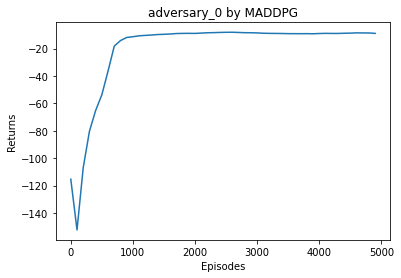

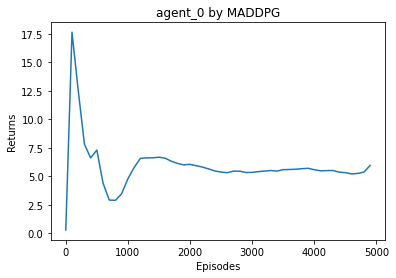

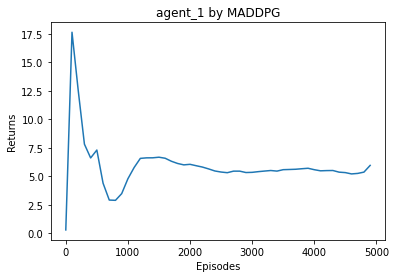

In [8]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(
        np.arange(return_array.shape[0]) * 100,
        rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

- 可以看到，正常智能体agent_0和agent_1的回报结果完全一致，这是因为它们的奖励函数完全一样。正常智能体最终保持了正向的回报，说明它们通过合作成功地占领了两个不同的地点，进而让对抗智能体无法知道哪个地点是目标地点。另外，我们也可以发现 MADDPG 的收敛速度和稳定性都比较不错。

## 21.4 小结
- 本章讲解了多智能体强化学习 CTDE 范式下的经典算法 MADDPG，MADDPG 后续也衍生了不少多智能体强化学习算法。因此，理解 MADDPG 对深入探究多智能体算法非常关键，有兴趣的读者可阅读 MADDPG 原论文加深理解。